# Lab 6: Kernel Methods
Support Vector Machines are powerful methods, but they also require careful tuning. We'll explore SVM kernels and hyperparameters on an artificial dataset. We'll especially look at model underfitting and overfitting.

In [ ]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
from matplotlib import cm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 1.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.3 MB/s eta 0:00:00
  Created wheel for openml: filename=openml-0.14.2-py3-none-any.whl size=158699 sha256=9b2b91799f63921c4eadaffd184cea1326efffd56f844863ee630f9398273034
  Stored in directory: /root/.cache/pip/wheels/2e/4e/af/5e721761d86375dbca82e63cc2470019e97815bc39f11451ea
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=0a4caa5f84d842b140e416a85d24236a77d8ebdeb6508e51bd40ecc9eba2cff5
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built 

## Getting the data
We fetch the Banana data from OpenML: https://www.openml.org/d/1460  

In [ ]:
bananas = oml.datasets.get_dataset(1460) # Banana data has OpenML ID 1460
X, y, _, _ = bananas.get_data(target=bananas.default_target_attribute, dataset_format='array');

<ipython-input-2-9c8e7641ea56>:1: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  bananas = oml.datasets.get_dataset(1460) # Banana data has OpenML ID 1460
<ipython-input-2-9c8e7641ea56>:2: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, _ = bananas.get_data(target=bananas.default_target_attribute, dataset_format='array');


Quick look at the data:

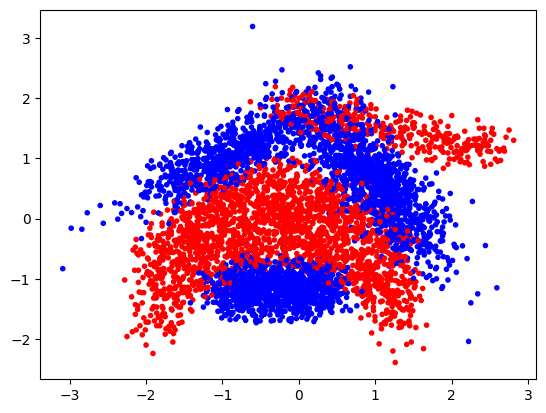

In [ ]:
plt.scatter(X[:,0], X[:,1], c=y,cmap=plt.cm.bwr, marker='.');

In [ ]:
pd.DataFrame(X).head()

,0,1
0,1.140,-0.114
1,-1.520,-1.150
2,-1.050,0.720
3,-0.916,0.397
4,-1.090,0.437


In [ ]:
# Plotting helpers. Based loosely on https://github.com/amueller/mglearn

def plot_svm_kernel(X, y, title, support_vectors, decision_function, dual_coef=None, show=True):
    """
    Visualizes the SVM model given the various outputs. It plots:
    * All the data point, color coded by class: blue or red
    * The support vectors, indicated by circling the points with a black border.
      If the dual coefficients are known (only for kernel SVMs) if paints support vectors with high coefficients darker
    * The decision function as a blue-to-red gradient. It is white where the decision function is near 0.
    * The decision boundary as a full line, and the SVM margins (-1 and +1 values) as a dashed line

    Attributes:
    X -- The training data
    y -- The correct labels
    title -- The plot title
    support_vectors -- the list of the coordinates of the support vectores
    decision_function - The decision function returned by the SVM
    dual_coef -- The dual coefficients of all the support vectors (not relevant for LinearSVM)
    show -- whether to plot the figure already or not
    """
    # plot the line, the points, and the nearest vectors to the plane
    #plt.figure(fignum, figsize=(5, 5))
    plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.bwr, marker='.')
    if dual_coef is not None:
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1], c=dual_coef[0, :],
                    s=70, edgecolors='k', zorder=10, marker='.', cmap=plt.cm.bwr)
    else:
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1], facecolors='none',
                    s=70, edgecolors='k', zorder=10, marker='.', cmap=plt.cm.bwr)
    plt.axis('tight')
    x_min, x_max = -3.5, 3.5
    y_min, y_max = -3.5, 3.5

    XX, YY = np.mgrid[x_min:x_max:300j, y_min:y_max:300j]
    Z = decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-1, 0, 1])
    plt.pcolormesh(XX, YY, Z, vmin=-1, vmax=1, cmap=plt.cm.bwr, alpha=0.1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())

    if show:
        plt.show()

def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    """
    Visualizes the results of a grid search with two hyperparameters as a heatmap.
    Attributes:
    values -- The test scores
    xlabel -- The name of hyperparameter 1
    ylabel -- The name of hyperparameter 2
    xticklabels -- The values of hyperparameter 1
    yticklabels -- The values of hyperparameter 2
    cmap -- The matplotlib color map
    vmin -- the minimum value
    vmax -- the maximum value
    ax -- The figure axes to plot on
    fmt -- formatting of the score values
    """
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=90)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center", size=10)
    return img

## Exercise 1: Linear SVMs

First, we'll look at linear SVMs and the different outputs they produce. Check the [documentation of LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)

The most important inputs are:  
* C -- The C hyperparameter controls the misclassification cost and therefore the amount of regularization. Lower values correspond to more regularization
* loss - The loss function, typically 'hinge' or 'squared_hinge'. Squared hinge is the default. Normal hinge is less strict.
* dual -- Whether to solve the primal optimization problem or the dual (default). The primal is recommended if you have many more data points than features (although our datasets is very small, so it won't matter much).

The most important outputs are:  
* decision_function - The function used to classify any point. In this case on linear SVMs, this corresponds to the learned hyperplane, or $y = \mathbf{wX} + b$. It can be evaluated at every point, if the result is positive the point is classified as the positive class and vice versa.
* coef_ - The model coefficients, i.e. the weights $\mathbf{w}$
* intercept_ - the bias $b$

From the decision function we can find which points are support vectors and which are not: the support vectors are all
the points that fall inside the margin, i.e. have a decision value between -1 and 1, or that are misclassified. Also see the lecture slides.

### Exercise 1.1: Linear SVMs
Train a LinearSVC with C=0.001 and hinge loss. Then, use the plotting function `plot_svm_kernel` to plot the results. For this you need to extract the support vectors from the decision function. There is a hint below should you get stuck.
Interpret the plot as detailed as you can. Afterwards you can also try some different settings. You can also try using the primal instead of the dual optimization problem (in that case, use squared hinge loss).

* USING DUAL

<ipython-input-5-61556f8dd89e>:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(support_vectors[:, 0], support_vectors[:, 1], facecolors='none',


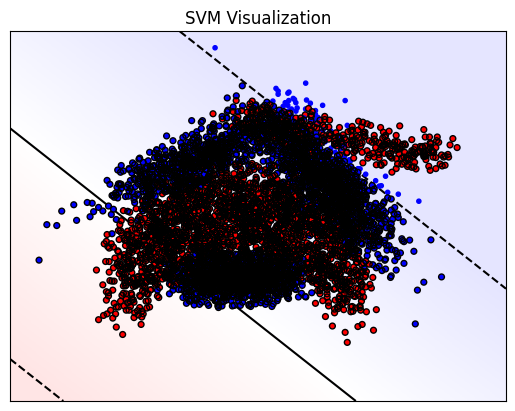

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Model
pipline = make_pipeline(StandardScaler(), LinearSVC(C=0.001, dual=True, loss="hinge", random_state=0, tol=1e-5))
pipline.fit(X, y)
clf = pipline.named_steps['linearsvc']

# Hint: how to compute the support vectors from the decision function
support_vector_indices = np.where((2 * y - 1) * clf.decision_function(X) <= 1)[0]
support_vectors = X[support_vector_indices]

# Plot
plot_svm_kernel(X, y, "SVM Visualization", support_vectors, clf.decision_function, dual_coef=None, show=True)

* USING PRIMAL

<ipython-input-5-61556f8dd89e>:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(support_vectors[:, 0], support_vectors[:, 1], facecolors='none',


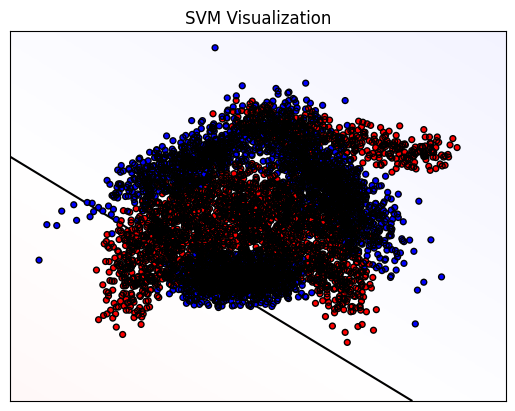

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Model
pipline = make_pipeline(StandardScaler(), LinearSVC(C=0.001, dual=False, loss="squared_hinge", random_state=0, tol=1e-5))
pipline.fit(X, y)
clf = pipline.named_steps['linearsvc']

# Hint: how to compute the support vectors from the decision function
support_vector_indices = np.where((2 * y - 1) * clf.decision_function(X) <= 1)[0]
support_vectors = X[support_vector_indices]

# Plot
plot_svm_kernel(X, y, "SVM Visualization", support_vectors, clf.decision_function, dual_coef=None, show=True)

**Interpretation**
> In both situations, almost all the points are support vectors and they fall within the margin zone. So, linear SVM does not perform so well.<br>
> In the first test case where we used the dual function and the 'hinge' optimizer, we observe that all the points lie within the margin between the dashed lines and the main line. Therefore, the linear SVM used does not perform classification effectively.<br>
Additionally, despite changing the loss function and using the primal function for optimization, we notice that the decision boundaries do not separate the two classes. We could thus conclude that the data is not linearly separable and that we need to use kernels to improve the results with nonlinear models.

## Exercise 2: Kernelized SVMs

Check the [documentation of SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

It has a few more inputs. The most important:
* kernel - It must be either ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, or your custom defined kernel.
* gamma - The kernel width of the `rbf` (Gaussian) kernel. Smaller values mean wider kernels.
          Only relevant when selecting the rbf kernel.
* degree - The degree of the polynomial kernel. Only relevant when selecting the poly kernel.

There also also more outputs that make our lifes easier:  
* support_vectors_ - The array of support vectors
* n_support_ - The number of support vectors per class
* dual_coef_ - The coefficients of the support vectors (the dual coefficients)

### Exercise 2.1

Evaluate different kernels, with their default hyperparameter settings.
Outputs should be the 5-fold cross validated accuracy scores for the linear kernel (lin_scores), polynomial kernel (poly_scores) and RBF kernel (rbf_scores). Print the mean and variance of the scores and give an initial interpretation of the performance of each kernel.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC

kernel_list = ['linear', 'poly', 'rbf']
train_mean, test_mean = [], []
train_var, test_var = [], []

for kernel in kernel_list:
  model = SVC(kernel=kernel)
  model_results = cross_validate(model, X, y, cv=5, n_jobs=-1, return_train_score=True)
  train_mean.append(np.mean(model_results["train_score"]))
  test_mean.append(np.mean(model_results["test_score"]))
  train_var.append(np.var(model_results["train_score"]))
  test_var.append(np.var(model_results["test_score"]))

df = pd.DataFrame({
    "Kernel": kernel_list,
    "Train Mean": train_mean,
    "Train Variance": train_var,
    "Test Mean": test_mean,
    "Test Variance": test_var,
})
print(df.to_string())

   Kernel  Train Mean  Train Variance  Test Mean  Test Variance
0  linear    0.551698    8.899964e-09   0.551698   1.423994e-07
1    poly    0.638443    1.835618e-05   0.637736   3.025988e-05
2     rbf    0.904292    1.566394e-06   0.902453   5.432538e-05


**Interpretation**
> We observe that the linear model performs the worst with a test mean score of 0.55 and low variance. As for the model with the polynomial kernel, its average test score is 0.63, with a slight increase in variance compared to the linear model. Finally, the RBF (Radial Basis Function) model is the best with a score of 0.90, with slightly higher variance than the linear and polynomial models.

## Exercise 2: Visualizing the fit
To better understand what the different kernels are doing, let's visualize their predictions.

### Exercise 2.1
Call and fit SVM with linear, polynomial and RBF kernels with default parameter values. For RBF kernel, use kernel coefficient value (gamma) of 2.0. Plot the results for each kernel with "plot_svm_kernel" function. The plots show the predictions made for the different kernels. The background color shows the prediction (blue or red). The full line shows the decision boundary, and the dashed line the margin. The encircled points are the support vectors.

In [ ]:
# Prediction per model
def plot_svm(model, title):
  clf = model.fit(X, y)
  plot_svm_kernel(X, y, title, clf.support_vectors_, clf.decision_function, dual_coef=clf.dual_coef_, show=True)

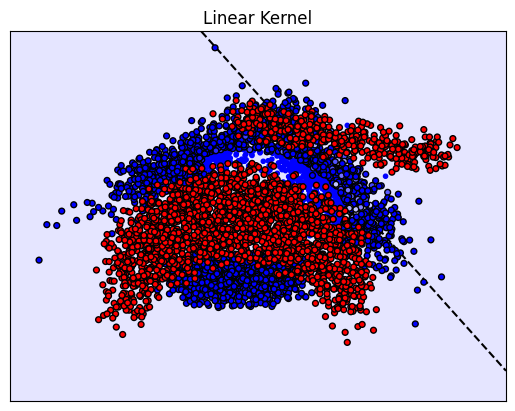

In [ ]:
plot_svm(SVC(kernel='linear', gamma=2.0), "Linear Kernel")

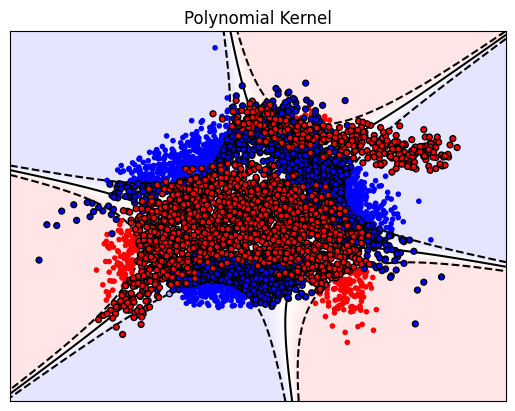

In [ ]:
plot_svm(SVC(kernel='poly', gamma=2.0), "Polynomial Kernel")

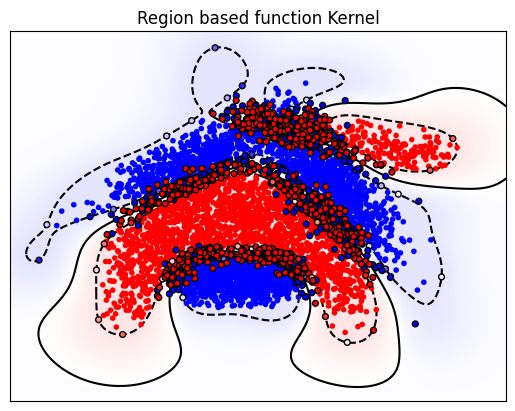

In [ ]:
plot_svm(SVC(kernel='rbf', gamma=2.0), "Region based function Kernel")

### Exercise 2.2
Interpret the plots for each kernel. Think of ways to improve the results.

**Interpretation**
> - RBF<br>
> We observe that among the three models, the model with the RBF kernel is the one that separates the classes with the highest precision. This is consistent with the results from section 2.1 where we obtained the highest performance for the model with RBF. Regarding the RBF, we could intuitively try to tune the hyperparameters to achieve more precision at these boundaries.
> - Linear & Polynomial<br>
> For these two models, the linear one does not distinguish between the classes (since it predicts all classes as being blue). Whereas the polynomial model separates classes at the extremes but struggles with points in the center (Indeed, the polynomial model does not effectively separate the points in the middle because the decision boundaries adopt shapes that do not really allow separation in the middle.). <br>

## Exercise 3: Visualizing the RBF models and hyperparameter space
Select the RBF kernel and optimize the two most important hyperparameters (the 𝐶 parameter and the kernel width 𝛾 ).

Hint: values for C and $\gamma$ are typically in [$2^{-15}..2^{15}$] on a log scale.

### Exercise 3.1
First try 3 very different values for $C$ and $\gamma$ (for instance [1e-3,1,1e3]). For each of the 9 combinations, create the same RBF plot as before to understand what the model is doing. Also create a standard train-test split and report the train and test score. Explain the performance results. When are you over/underfitting? Can you see this in the predictions?

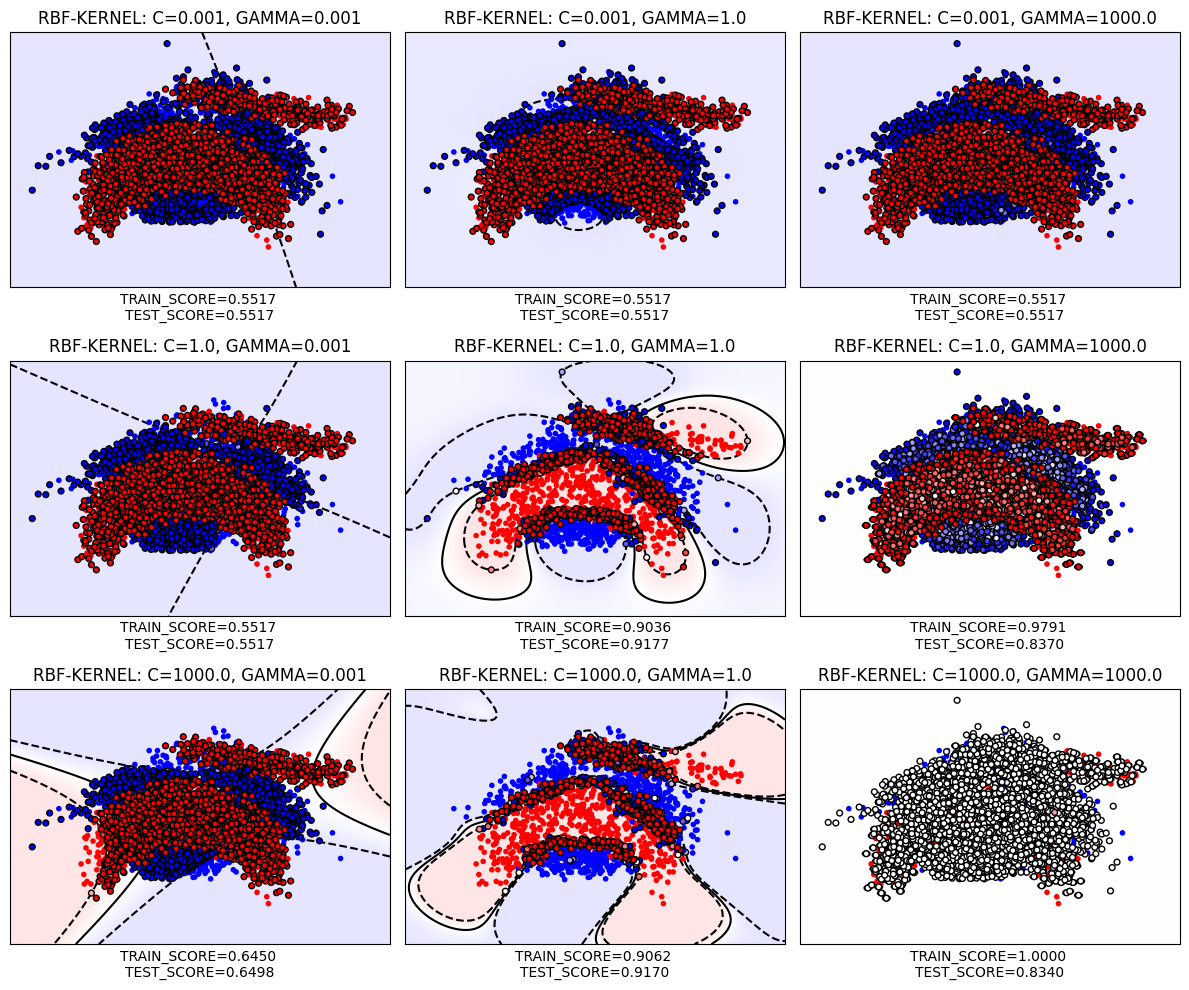

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# STANDARD TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# HYPERPARAMETERS LIST
C_values     = np.geomspace(1e-3, 1e3, 3)
gamma_values = np.geomspace(1e-3, 1e3, 3)
plot_pos     = 1

plt.figure(figsize=(12, 10))
for C in C_values:
  for gamma in gamma_values:
    model = SVC(kernel='rbf', C=C, gamma=gamma)
    clf = model.fit(X_train, y_train)
    score_train = "{:.4f}".format(clf.score(X_train, y_train))
    score_test  = "{:.4f}".format(clf.score(X_test, y_test))

    plt.subplot(3, 3, plot_pos)
    plot_svm_kernel(X_test, y_test, f"RBF-KERNEL: C={C}, GAMMA={gamma}", clf.support_vectors_, clf.decision_function, dual_coef=clf.dual_coef_, show=False)
    plt.xlabel(f"TRAIN_SCORE={score_train} \nTEST_SCORE={score_test}")
    plot_pos += 1

plt.tight_layout()
plt.show()

**Interpretation**
> - Underfitting<br>
For the case C=0.001 (on the first line) and for the case C=0.1 and gamma=0.01, we observe that the background of the image is blue. The model underfits in this case. This is also justified by the train and test scores, which are all equal to 0.55(naives model).
> - Overfitting<br>
For the cases (C=1, gamma=1000) and (C=1000, gamma=1000), we see that almost all points are support vectors, and the decision boundaries are around each point. These models attach too much to the data and thus have erroneous predictions on any new data. This is justified by obtaining a score of 0.99 on the train but a score of 0.84 on the test and a train score of 0.97 on the train but a low score of 0.89 on the test for the cases (C=1000, gamma=1000) and (C=1, gamma=1000).
> - Generalisation
>  - GAMMA: 0.001 et C=1000<br>
We observe that the decision boundary is not very effective since there are several elements that are misclassified, and most of the points are support vectors. But this model is better than the previous ones. It is accurate to 64%.
>  - GAMMA: 1000 et C=1000<br>
Here we observe that the decision boundary manages to identify the red class and leaves the rest of the surface for the blue class. The training score is 0.91 compared to 0.90 for the test, which is acceptable.
>  - GAMMA:1, C:1
We obtain the highest performance with the aforementioned parameters. Indeed, the model manages to capture the zones delimiting the red class as well as those delimiting the blue class. The scores are similar to the previous case except that this model is slightly more performant on the test than the previous one.

### Exercise 3.2
Optimize the hyperparameters using a grid search, trying every possible combination of C and gamma. Show a heatmap of the results and report the optimal hyperparameter values. Use at least 10 values for $C$ and $\gamma$ in [$2^{-15}..2^{15}$] on a log scale. Report accuracy under 3-fold CV. We recommend to use sklearn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and the `heatmap` function defined above. Check their documentation.

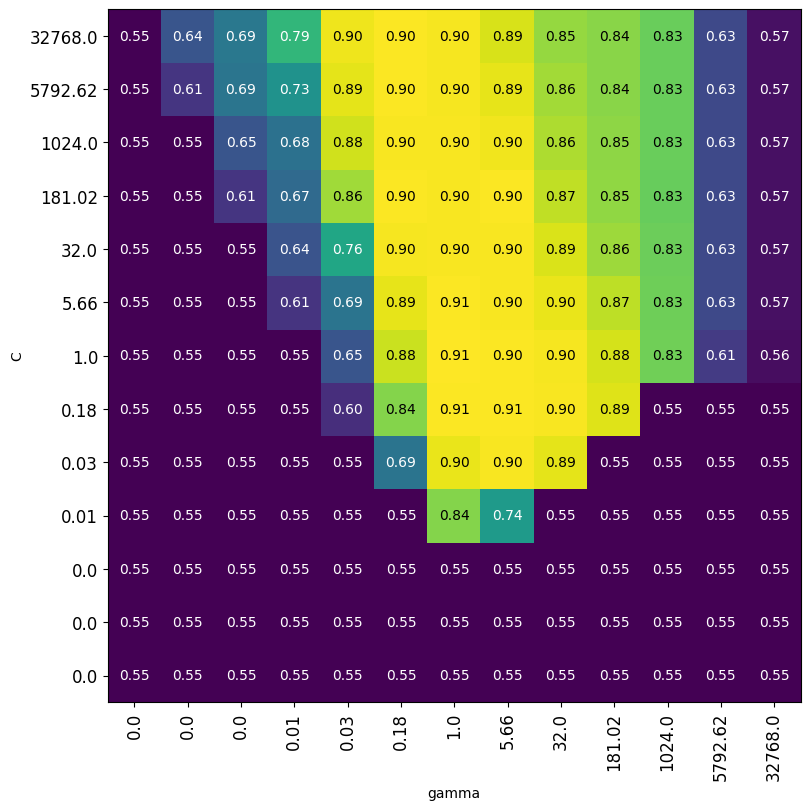

In [14]:
from sklearn.model_selection import GridSearchCV

# GRID SSEARCH
nbr_point   = 13
model       = SVC(kernel='rbf')
parameters  = {'C': np.logspace(-15, 15, nbr_point, base=2), 'gamma': np.logspace(-15, 15, nbr_point, base=2)}
grid_search = GridSearchCV(model, parameters, cv=3, n_jobs=-1);
grid_search.fit(X, y);

# HEATMAP PLOT
mean_test_score = grid_search.cv_results_['mean_test_score']
mean_test_score = mean_test_score.reshape(nbr_point, nbr_point)
xlabels = np.round(parameters['gamma'], 2)
ylabels = np.round(parameters['C'], 2)
plt.figure(figsize=(9, 9))
heatmap(mean_test_score, xlabel="gamma", ylabel="C", xticklabels=xlabels, yticklabels=ylabels, cmap=None, vmin=None, vmax=None, ax=None, fmt="%0.2f")

**Interpretation**
> After optimizing the hyperparameters C and gamma, we can easily identify on this heatmap the combinations that maximize our precision in order to use them in production. The maximum value obtained being 0.91, we can note the following combinations that allow us to achieve this score: (gamma=1, C=0.18), (gamma=5.66, C=0.18), (gamma=0.18, C=5.66), (gamma=1, C=1).

In [15]:
#END LAB - GÉNÉREUX AKOTENOU